In [1]:
%load_ext autoreload
%autoreload 2
%load_ext rpy2.ipython

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import os

import utils

from rpy2.robjects.packages import importr
from rpy2 import robjects
import rpy2.robjects.numpy2ri
import pandas as pd
from rpy2.robjects import pandas2ri
rstanarm = importr('rstanarm')
rpy2.robjects.numpy2ri.activate()
pandas2ri.activate()

import tqdm
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.datasets import load_diabetes
from sklearn.preprocessing import StandardScaler

In [3]:
def set_random_seeds (seed=1234):
    np.random.seed(seed)
    torch.manual_seed(seed)
def load_diabetes_dataset(device='cuda'):
    df = load_diabetes()
    scaler = StandardScaler()
    X_np = scaler.fit_transform(df.data)
    y_np = scaler.fit_transform(df.target.reshape(-1, 1))[:, 0]
    X_tensor = torch.from_numpy(X_np).float().to(device)
    y_tensor = torch.from_numpy(y_np).float().to(device)

    # compute regression parameters
    reg = LinearRegression().fit(X_np, y_np)
    r2_score = reg.score(X_np, y_np)
    print(f"R^2 score: {r2_score:.4f}")
    sigma_regr = np.sqrt(np.mean(np.square(y_np - X_np @ reg.coef_)))
    print(f"Sigma regression: {sigma_regr:.4f}")
    print(f"Norm coefficients: {np.linalg.norm(reg.coef_):.4f}")

    return X_tensor, y_tensor, X_np, y_np

In [4]:
device = 'cuda'
set_random_seeds(1234)

dir_name = "./plots/"
if not os.path.exists(dir_name):
    os.makedirs(dir_name)

# load data
X_tensor, y_tensor, X_np, y_np = load_diabetes_dataset(device=device)

# build model
flow_dim = X_tensor.shape[1]
q = 1
# flow = build_flow_manifold(flow_dim, norm=norm, q=q, n_layers=3, hidden_features=64, device=device)

R^2 score: 0.5177
Sigma regression: 0.6944
Norm coefficients: 0.8511


### Train conditional flow on manifold

In [5]:
# torch.autograd.set_detect_anomaly(False)
params_flow_manifold = dict(q=q,
                          sigma=torch.tensor(0.7),
                          lr=1e-3,
                          epochs=1000,
                          T0=5,
                          Tn=1,
                          iter_per_cool_step=100,
                          norm_min=0.01,
                          norm_max=2,#.4
                          sample_size=1,
                          context_size=1000,
                          device=device)

flow_manifold = utils.build_cond_flow_manifold(flow_dim, q=q, n_layers=5, context_features=128, hidden_features=256, device=device)

In [7]:
flow_manifold.load_state_dict(torch.load("./models/flow_manifold_T_1"))

<All keys matched successfully>

Training loss at step 0: 854.7 and 178.9 * (T = 5.000)
Training loss at step 1: 678.2 and 145.3 * (T = 5.000)
Training loss at step 2: 613.7 and 134.9 * (T = 5.000)
Training loss at step 3: 571.0 and 128.1 * (T = 5.000)
Training loss at step 4: 586.8 and 134.0 * (T = 5.000)
Training loss at step 5: 565.3 and 128.4 * (T = 5.000)
Training loss at step 6: 561.3 and 125.9 * (T = 5.000)
Training loss at step 7: 563.3 and 125.0 * (T = 5.000)
Training loss at step 8: 563.6 and 124.0 * (T = 5.000)
Training loss at step 9: 564.9 and 123.8 * (T = 5.000)
Training loss at step 10: 563.8 and 123.8 * (T = 5.000)
Training loss at step 11: 563.7 and 124.4 * (T = 5.000)
Training loss at step 12: 556.2 and 123.1 * (T = 5.000)
Training loss at step 13: 555.0 and 123.4 * (T = 5.000)
Training loss at step 14: 551.1 and 123.0 * (T = 5.000)
Training loss at step 15: 548.0 and 122.2 * (T = 5.000)
Training loss at step 16: 552.4 and 123.4 * (T = 5.000)
Training loss at step 17: 550.4 and 122.8 * (T = 5.000)
Tr

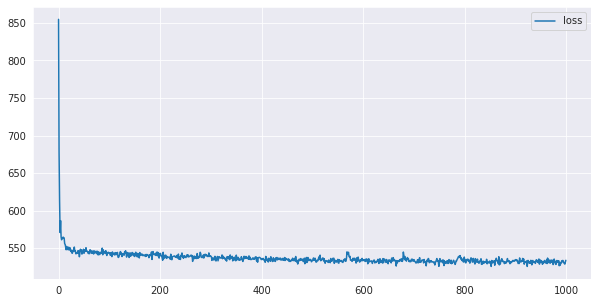

In [96]:
flow_manifold, loss, loss_T = utils.train_cond_manifold_model(flow_manifold, X=X_tensor, y=y_tensor, **params_flow_manifold)
torch.save(flow_manifold.state_dict(), "./models/flow_manifold_T_1")
flow_manifold.eval()
plt.figure(figsize=(10, 5))
plt.plot(range(len(loss)), loss, label='loss')
# plt.plot(range(len(loss)), loss_T, label='loss_T')
# plt.yscale("log")
plt.legend()
plt.show()

In [8]:
samples_sorted, norm_sorted, kl_sorted = utils.sample_beta(flow_manifold, X_tensor, y_tensor, sigma=params_flow_manifold['sigma'], norm_min=params_flow_manifold['norm_min'], 
                                                     norm_max=params_flow_manifold['norm_max'], context_size=1, sample_size=1000, n_iter=200, device='cuda')

100%|██████████| 200/200 [00:10<00:00, 18.62it/s]


100%|██████████| 2000/2000 [00:01<00:00, 1610.11it/s]


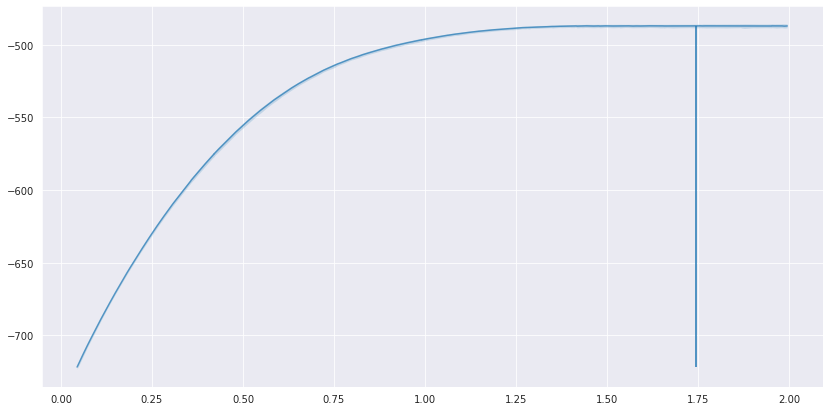

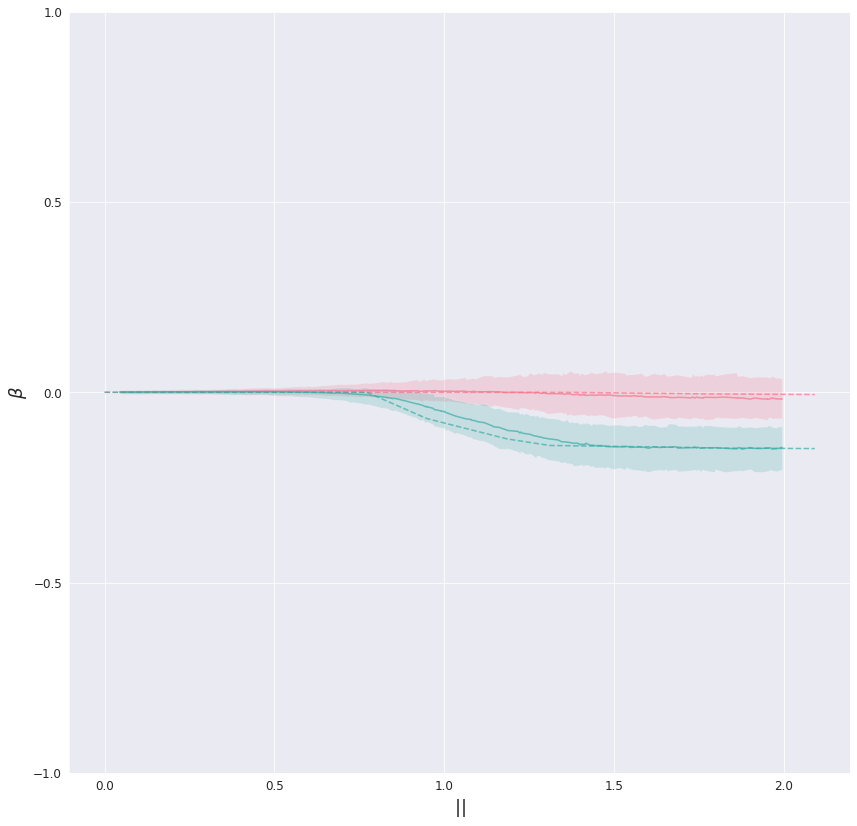

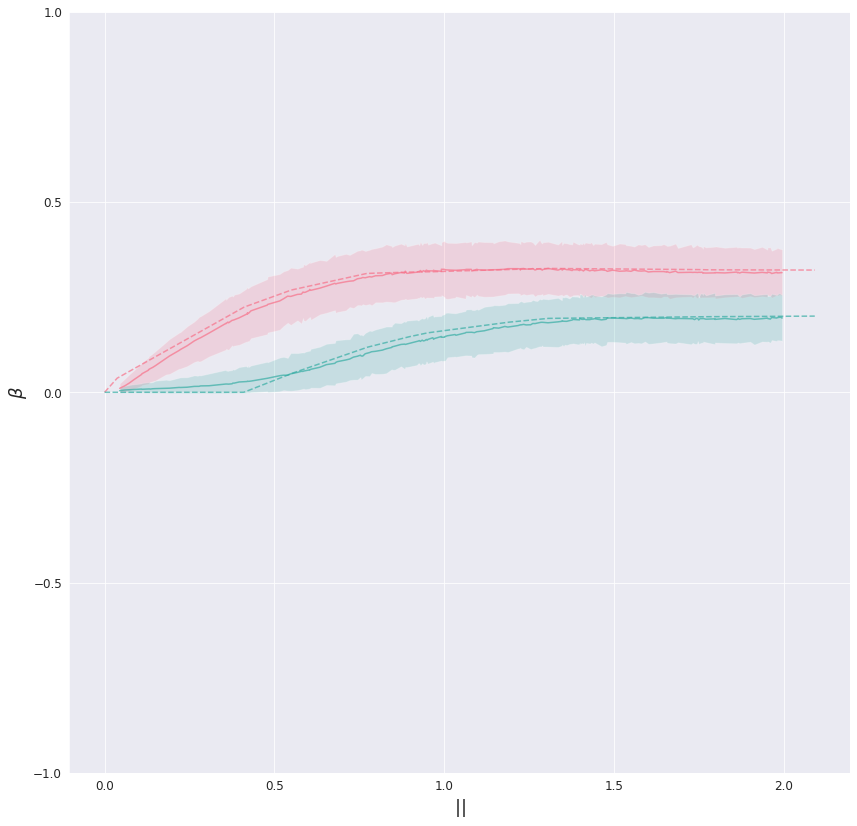

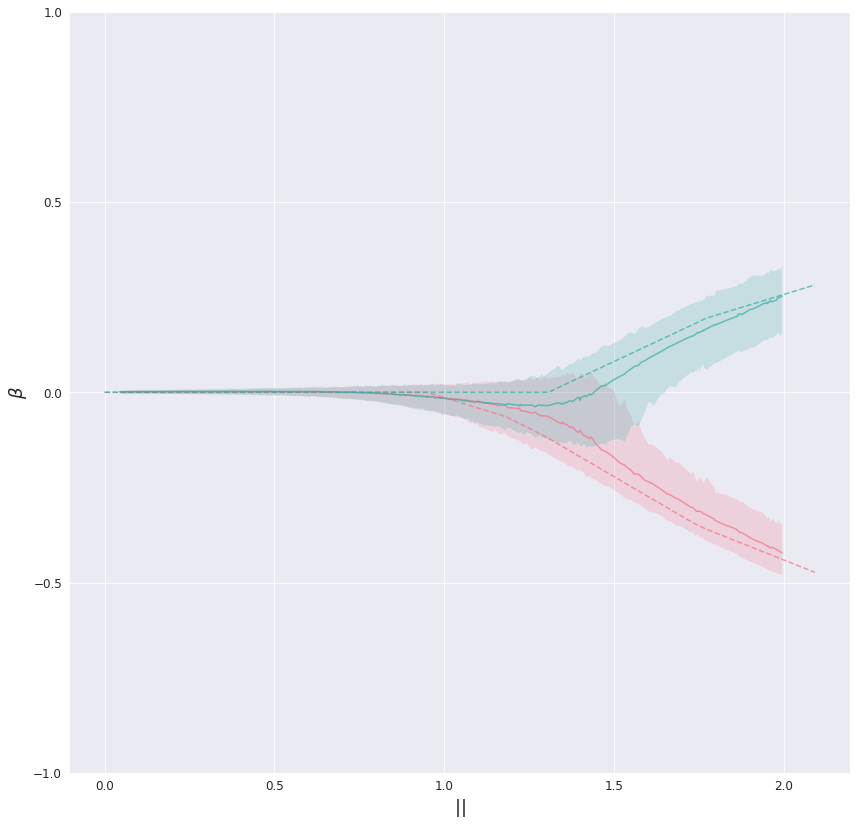

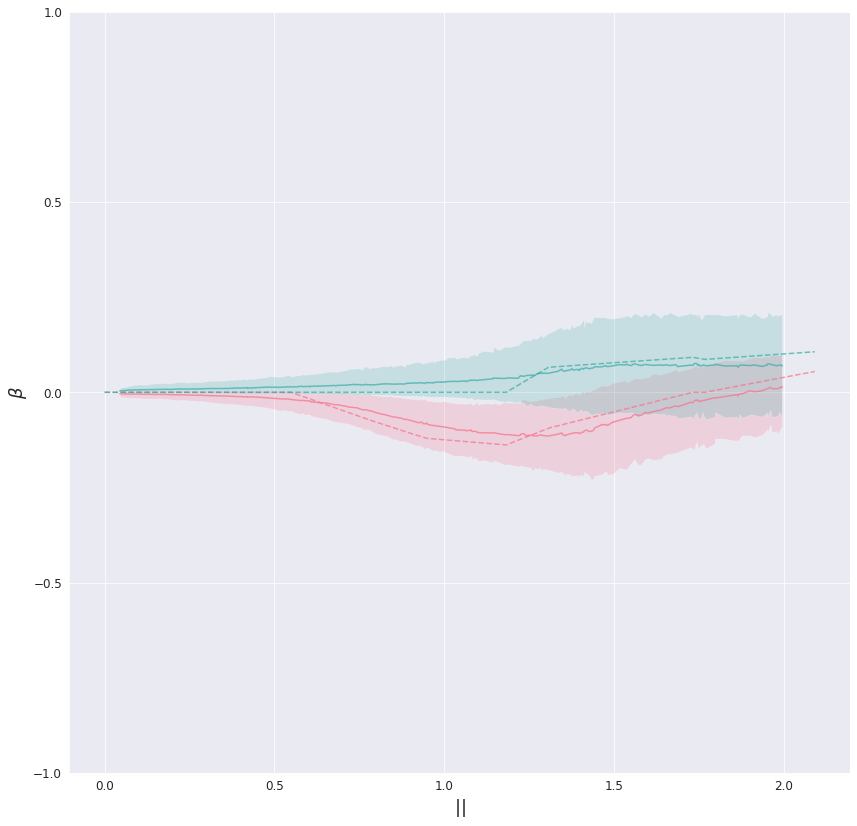

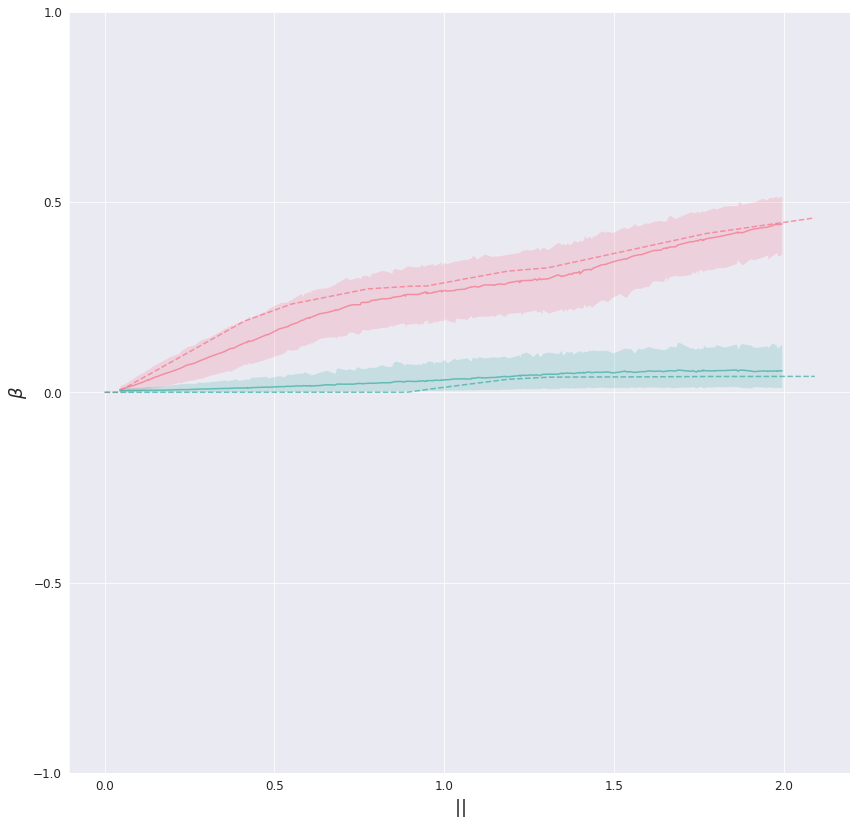

In [9]:
a = 0.95
marg_log_lik = -kl_sorted
l_quant = np.quantile(marg_log_lik, 1 - a, axis=1)
sample_mean = np.mean(marg_log_lik, axis=1)
r_quant = np.quantile(marg_log_lik, a, axis=1)

fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(norm_sorted, sample_mean, alpha=0.7, linewidth=1.5)
ax.fill_between(norm_sorted, l_quant, r_quant, alpha=0.2)
plt.vlines(norm_sorted[sample_mean.argmax()], ymin=sample_mean.min(), ymax=sample_mean.max())

utils.plot_betas_norm(samples_sorted, norm_sorted, X_np, y_np, norm=params_flow_manifold['q'], a=0.95, folder_name=dir_name, n_plots=5)

### Train conditional flow with Laplace prior

In [11]:
params_flow = dict(q=q,
                  sigma=torch.tensor(0.7),
                  lr=1e-4,
                  epochs=1000,
                  T0=20,
                  Tn=1,
                  iter_per_cool_step=50,
                  norm_min=0.01,
                  norm_max=2,#.4
                  lambda_min_exp=-1,
                  lambda_max_exp=3,
                  sample_size=1,
                  context_size=1000,
                  device=device)
flow = utils.build_cond_flow(flow_dim, q=q, n_layers=5, context_features=128, hidden_features=256, device=device)

In [45]:
flow.load_state_dict(torch.load("./models/flow_T_1"))

<All keys matched successfully>

Training loss at step 0: 5803.6 and 277.6 * (T = 20.000)
Training loss at step 1: 5374.9 and 256.5 * (T = 20.000)
Training loss at step 2: 4716.6 and 224.1 * (T = 20.000)
Training loss at step 3: 4161.5 and 197.1 * (T = 20.000)
Training loss at step 4: 3755.7 and 177.4 * (T = 20.000)
Training loss at step 5: 3435.3 and 162.1 * (T = 20.000)
Training loss at step 6: 2999.6 and 141.3 * (T = 20.000)
Training loss at step 7: 2859.2 and 134.8 * (T = 20.000)
Training loss at step 8: 2387.7 and 112.5 * (T = 20.000)
Training loss at step 9: 2167.8 and 102.5 * (T = 20.000)
Training loss at step 10: 1956.7 and 93.1 * (T = 20.000)
Training loss at step 11: 1776.1 and 85.1 * (T = 20.000)
Training loss at step 12: 1550.2 and 75.5 * (T = 20.000)
Training loss at step 13: 1428.5 and 70.4 * (T = 20.000)
Training loss at step 14: 1284.9 and 65.1 * (T = 20.000)
Training loss at step 15: 1166.7 and 60.1 * (T = 20.000)
Training loss at step 16: 1088.6 and 58.3 * (T = 20.000)
Training loss at step 17: 1003.

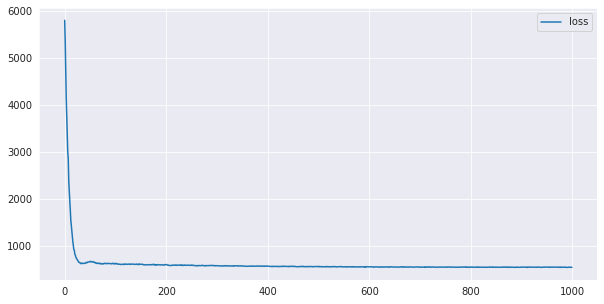

In [12]:
flow, loss, loss_T = utils.train_cond_model(flow, X=X_tensor, y=y_tensor, **params_flow)
torch.save(flow.state_dict(), "./models/flow_T_1")
flow.eval()
plt.figure(figsize=(10, 5))
plt.plot(range(len(loss)), loss, label='loss')
# plt.plot(range(len(loss)), loss_T, label='loss_T')
# plt.yscale("log")
plt.legend()
plt.show()

In [13]:
samples_sorted, lambda_sorted, kl_sorted = utils.sample_beta_exp(flow, X_tensor, y_tensor, sigma=params_flow['sigma'], lambda_min_exp=params_flow['lambda_min_exp'], 
                                                     lambda_max_exp=params_flow['lambda_max_exp'], context_size=1, sample_size=100, n_iter=1000, device='cuda')

100%|██████████| 1000/1000 [00:12<00:00, 81.38it/s]


100%|██████████| 1000/1000 [00:00<00:00, 1468.88it/s]


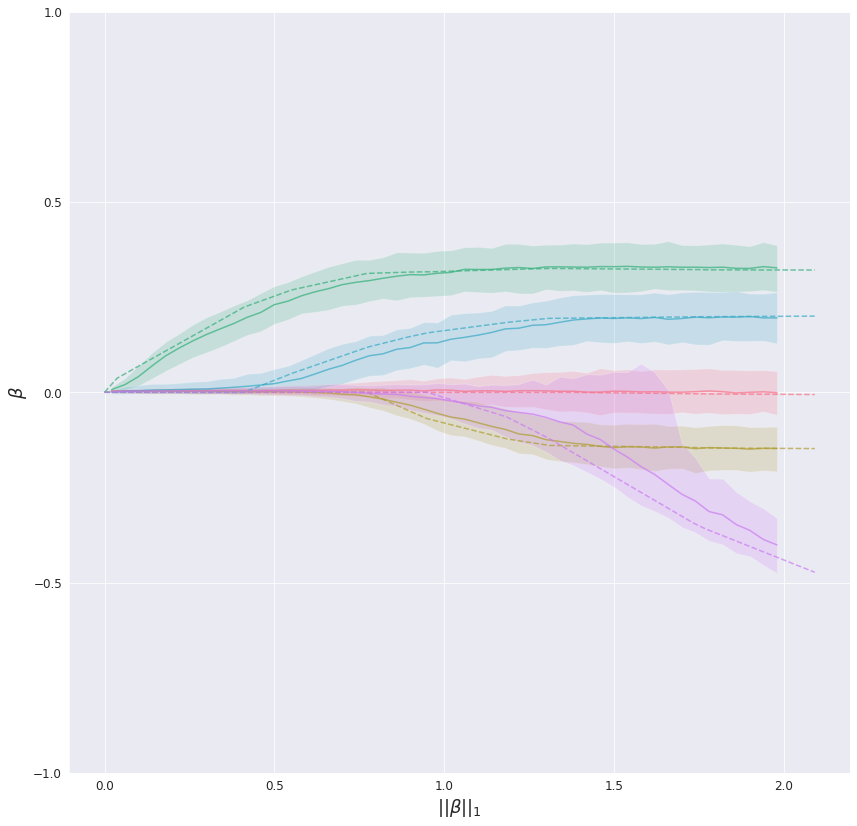

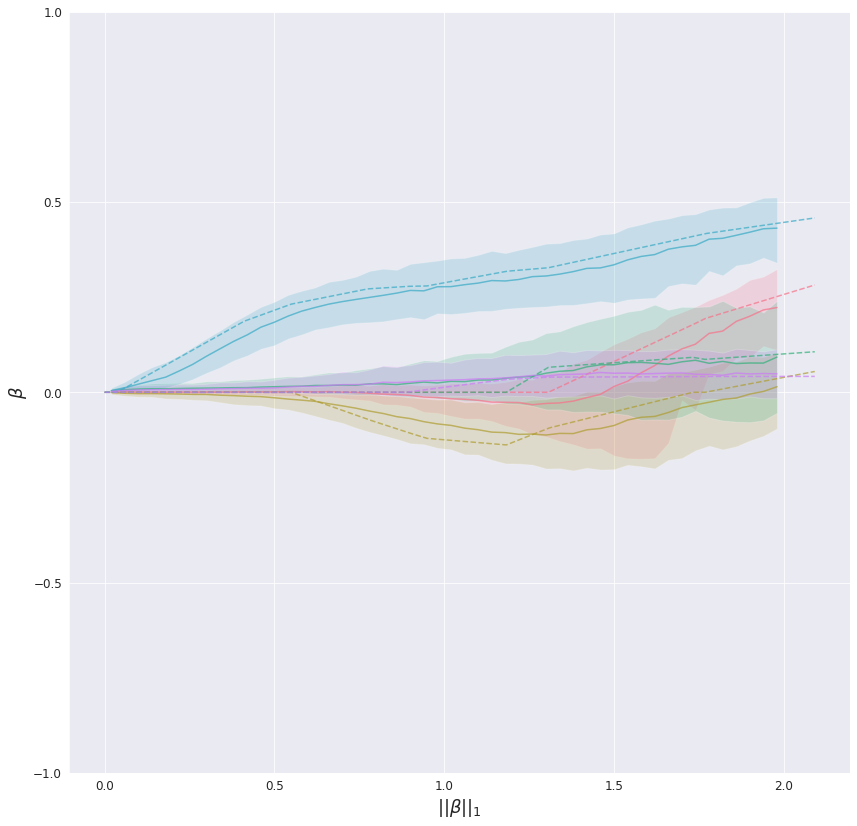

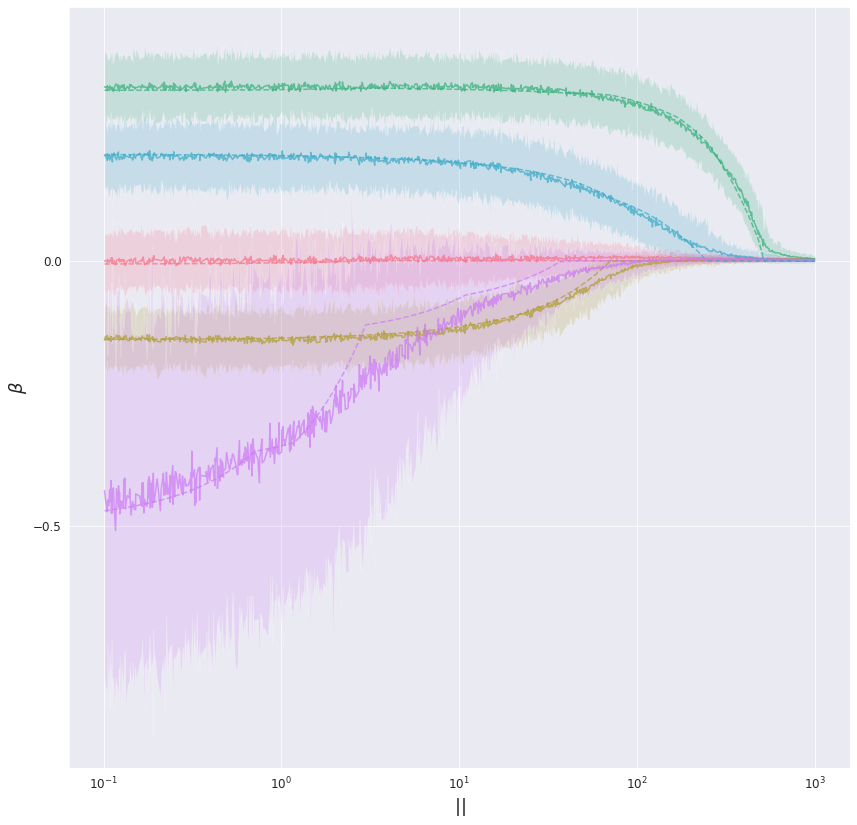

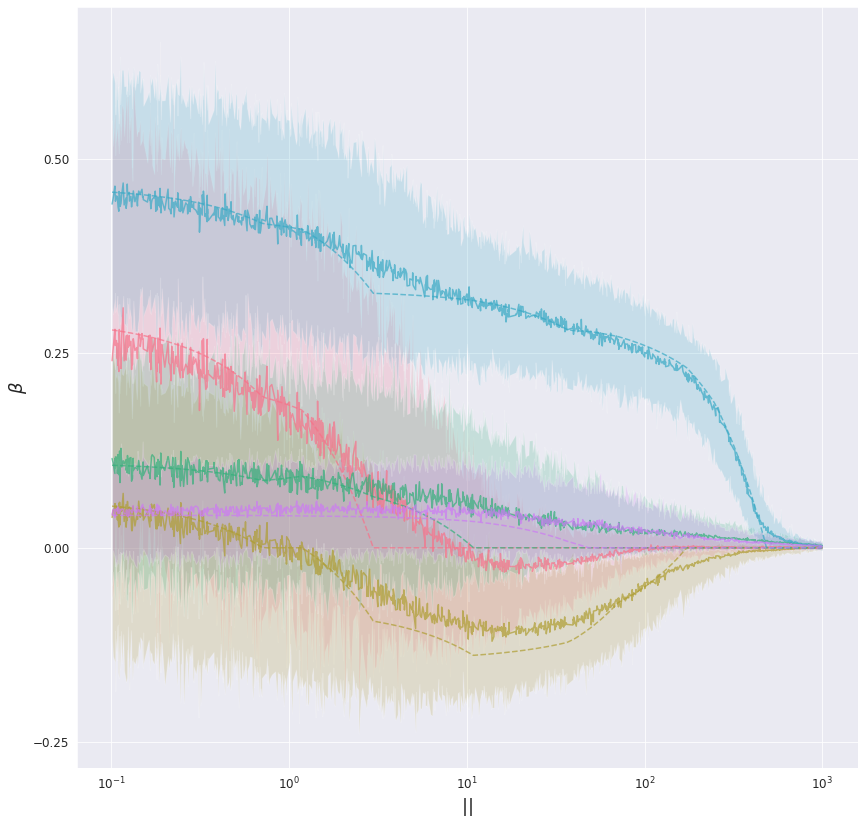

In [14]:
bins, samples_flow, l_flow, means_flow, r_flow = utils.plot_betas_lambda(samples_sorted, lambda_sorted,  X_np, y_np, norm=params_flow['q'], a=0.95, folder_name=dir_name, n_plots=2)

### Sample from Bayes Lasso

In [15]:
data_df = pd.DataFrame(np.c_[y_np,X_np], 
                       columns = ['target','0','1','2','3','4','5','6','7','8','9'])

In [16]:
# Defining the R script and loading the instance in Python
r = robjects.r
r['source']('bayes_lasso.R')# Loading the function we have defined in R.
bayes_function = robjects.globalenv['bayes_function']# Reading and processing data
bayes_function_opt_alpha  = (robjects.globalenv)['bayes_function_opt_alpha']# Reading and processing data

In [17]:
alphas_lasso = np.logspace(-1, 3, 100)
coefs, ci_l, ci_r, all_samples = [], [], [], []
conf = 0.95
for alpha in alphas_lasso:
    print("=+"*100)
    print('alpha: ', alpha)
    df_result = bayes_function(data_df, alpha=1/alpha, chain=1)
    bayes_samples = np.array(pd.DataFrame(df_result)).T
    bayes_samples = bayes_samples[:,1:-1]
    all_samples.append(bayes_samples)
    l_quant = np.quantile(bayes_samples, 1 - conf, axis=0)
    sample_mean = np.mean(bayes_samples, axis=0)
    r_quant = np.quantile(bayes_samples, conf, axis=0)
    coefs.append(sample_mean)
    ci_l.append(l_quant)
    ci_r.append(r_quant)

all_samples_raveled = np.concatenate(all_samples, 0)
all_samples = np.array(all_samples)
coefs = np.array(coefs)
ci_l = np.array(ci_l)
ci_r = np.array(ci_r)

=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+
alpha:  0.1

SAMPLING FOR MODEL 'continuous' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 4.4e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.44 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800

100%|██████████| 100/100 [00:00<00:00, 1486.86it/s]


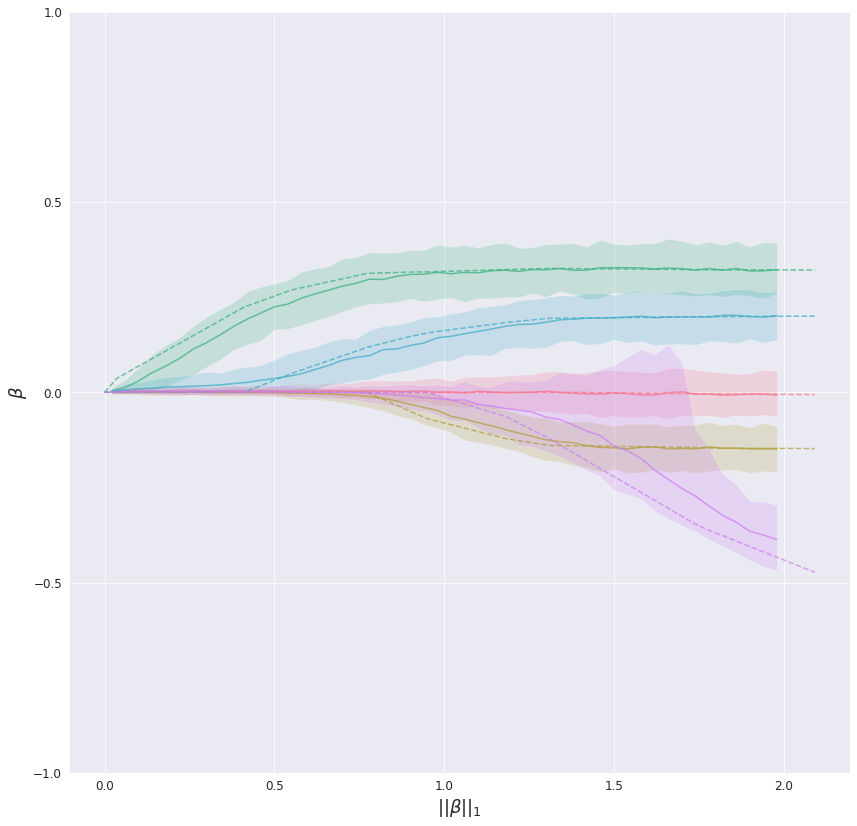

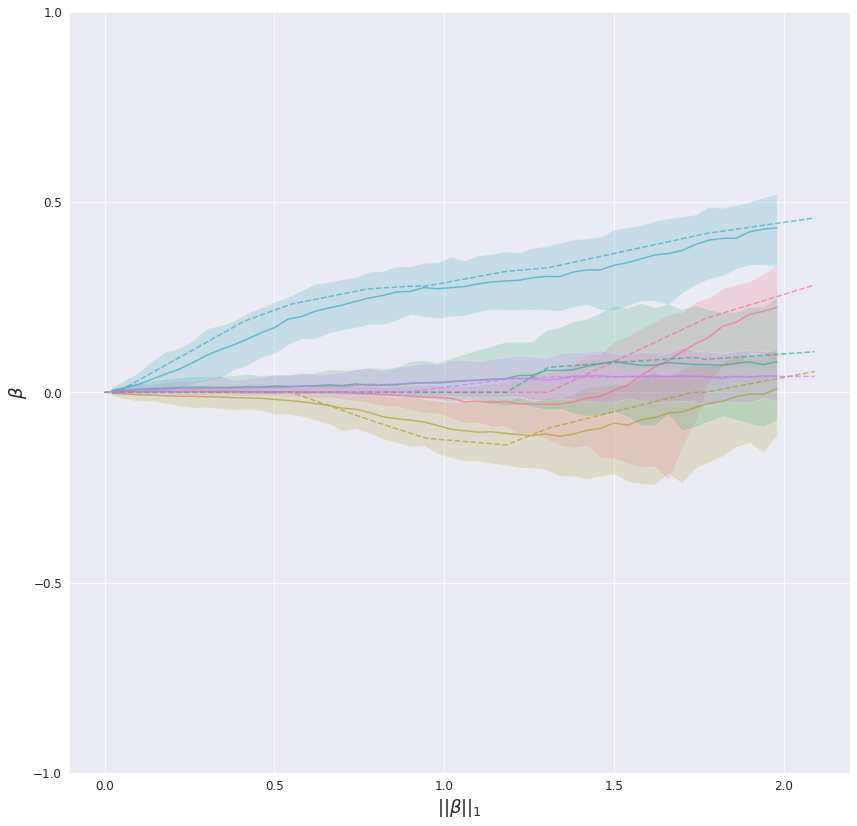

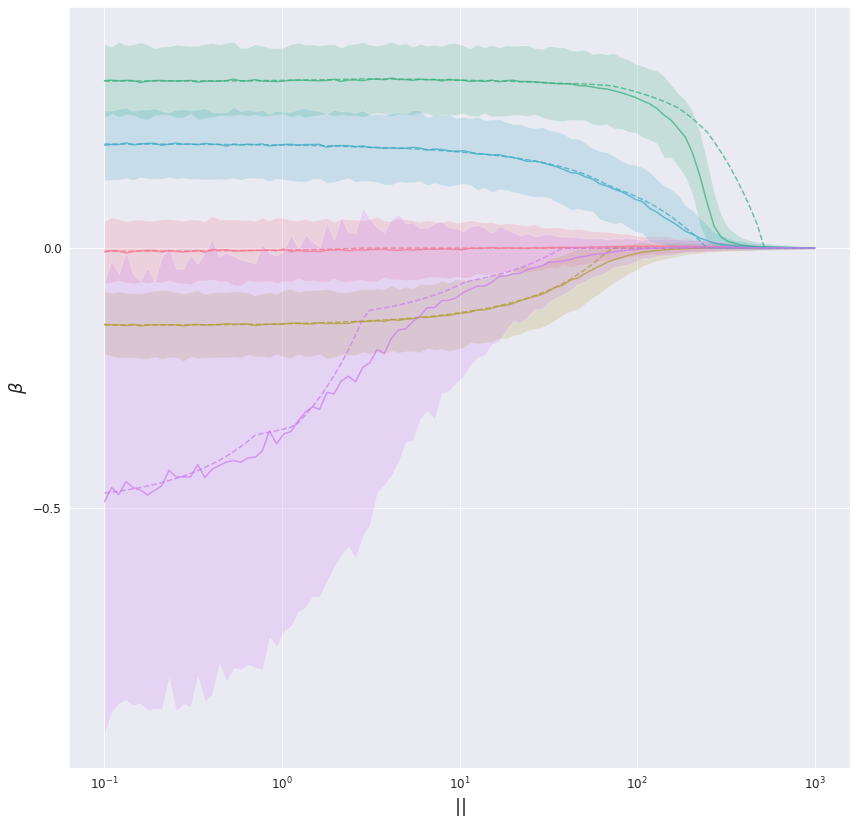

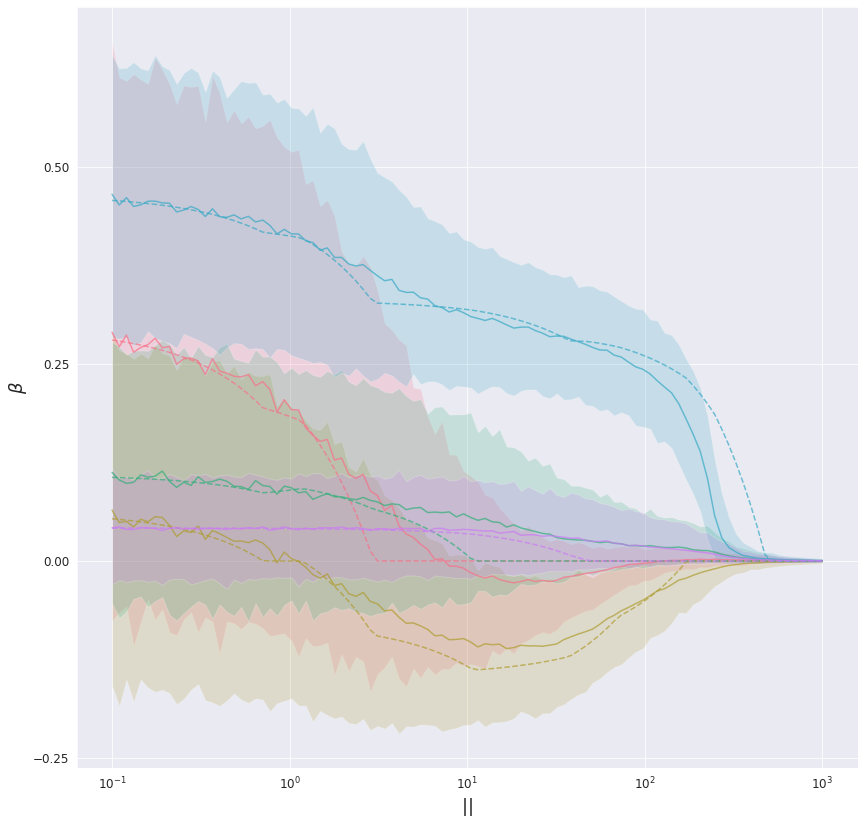

In [18]:
bins, samples_bayes, l_bayes, means_bayes, r_bayes = utils.plot_betas_lambda(all_samples, alphas_lasso,  X_np, y_np, norm=params_flow['q'], a=0.95, folder_name=dir_name, n_plots=2)

### Bayesian linear regression comparison 
- Bayesian linear regression
- Normalizing Flow with Laplace prior and conditioned on $\lambda$
- Normalizing Flow defined on L1 manifold and conditioned on $||\beta||_1=t$

In [39]:
# sample from NF with Laplace prior
flow = utils.build_cond_flow(flow_dim, q=q, n_layers=5, context_features=128, hidden_features=256, device=device)
flow.load_state_dict(torch.load("./models/flow_T_1"))
alphas_lasso = np.linspace(-1, 3, 10)
alphas_lasso_torch = torch.from_numpy(alphas_lasso).to(device).to(torch.float32).view(-1,1)
flow_samples, log_probs_samples = flow.sample_and_log_prob(1000, context=alphas_lasso_torch)
flow_samples_np = flow_samples.detach().cpu().numpy()
del flow_samples, log_probs_samples, flow
torch.cuda.empty_cache()
norms_flow = np.abs(flow_samples_np).sum(-1).mean(-1)

In [40]:
# sample from Bayesian Lasso 
coefs, ci_l, ci_r, norms_bayes_lasso = [], [], [], []
conf = 0.95
all_samples_bayes = {}
for alpha in 10**alphas_lasso:
    print("=+"*100)
    print('alpha: ', alpha)
    df_result = bayes_function(data_df, alpha=1/alpha, chain=1)
    bayes_samples = np.array(pd.DataFrame(df_result)).T
    bayes_samples = bayes_samples[:,1:-1]
    l_quant = np.quantile(bayes_samples, 1 - conf, axis=0)
    sample_mean = np.mean(bayes_samples, axis=0)
    r_quant = np.quantile(bayes_samples, conf, axis=0)
    sample_norm = np.abs(bayes_samples).sum(-1).mean()
    all_samples_bayes[f"{sample_norm:.4f}"] = bayes_samples
    norms_bayes_lasso.append(sample_norm)
    coefs.append(sample_mean)
    ci_l.append(l_quant)
    ci_r.append(r_quant)
    
coefs = np.array(coefs)
ci_l = np.array(ci_l)
ci_r = np.array(ci_r)
norms_bayes_lasso = np.array(norms_bayes_lasso)

=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+
alpha:  0.1

SAMPLING FOR MODEL 'continuous' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 7.7e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.77 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800

In [41]:
# sample from NF on manifold
flow_manifold = utils.build_cond_flow_manifold(flow_dim, q=q, n_layers=5, context_features=128, hidden_features=256, device=device)
flow_manifold.load_state_dict(torch.load("./models/flow_manifold_T_1"))
norms_flow_manifold = 0.5*(norms_bayes_lasso + norms_flow)
norms_flow_torch = torch.from_numpy(norms_flow_manifold).to(device).to(torch.float32).view(-1,1)
manifold_samples = []
for i in tqdm.tqdm(range(10)):
    flow_manifold_samples, log_probs_samples = flow_manifold.sample_and_log_prob(100, context=norms_flow_torch)
    manifold_samples.append(flow_manifold_samples.detach().cpu().numpy())
    del flow_manifold_samples, log_probs_samples
    torch.cuda.empty_cache()
flow_manifold_samples = np.concatenate(manifold_samples, 1)
del flow_manifold
torch.cuda.empty_cache()

100%|██████████| 10/10 [00:00<00:00, 13.40it/s]


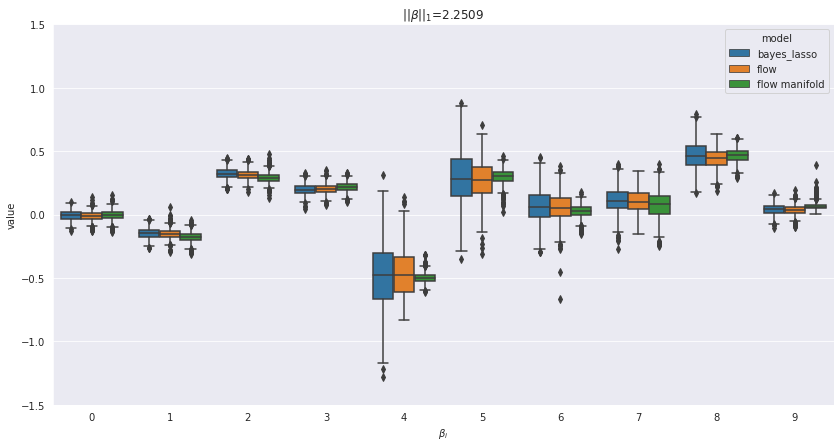

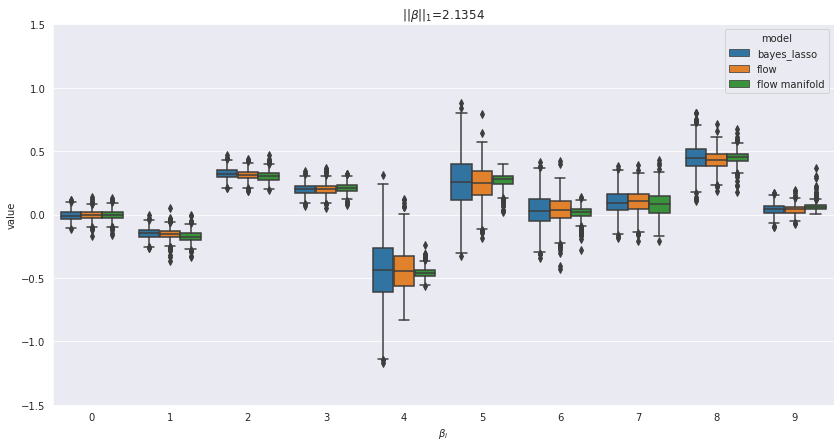

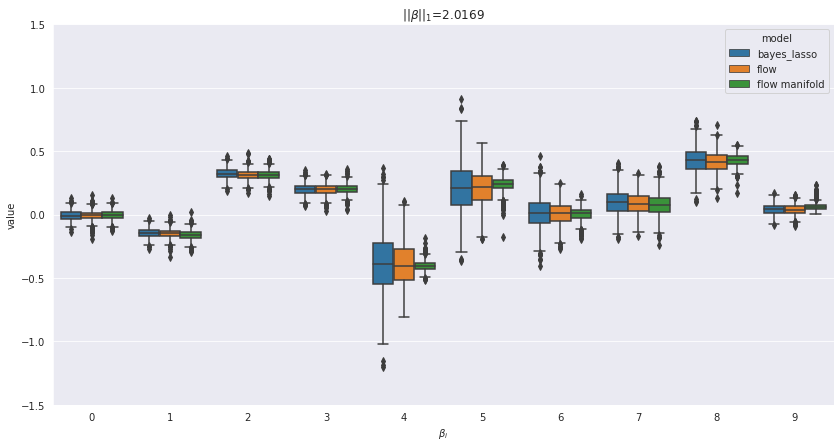

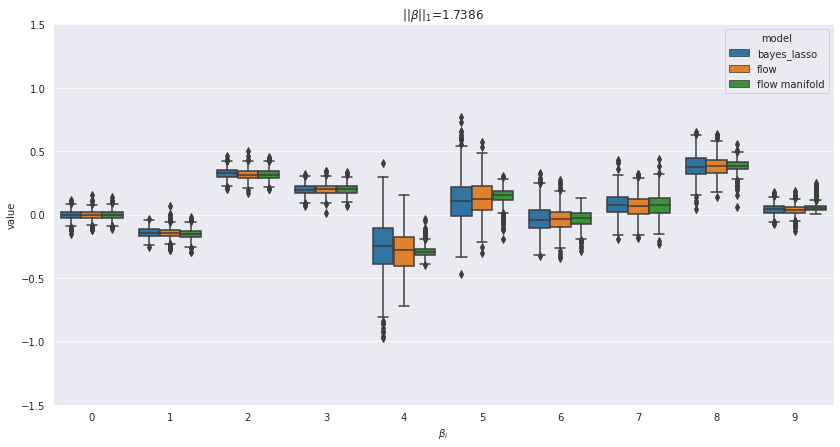

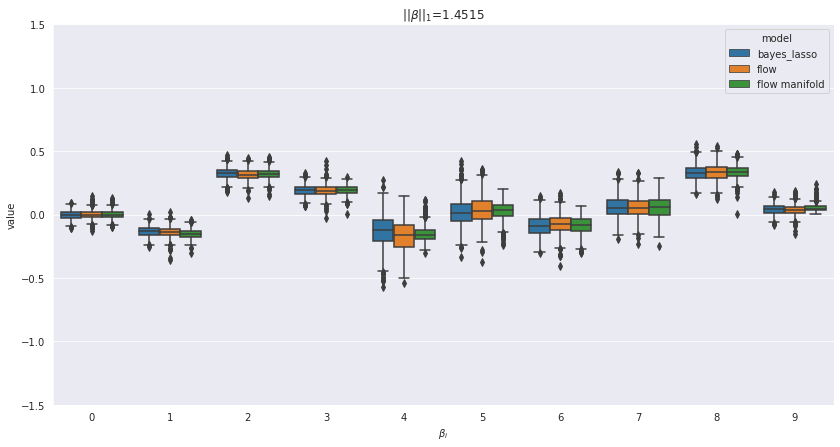

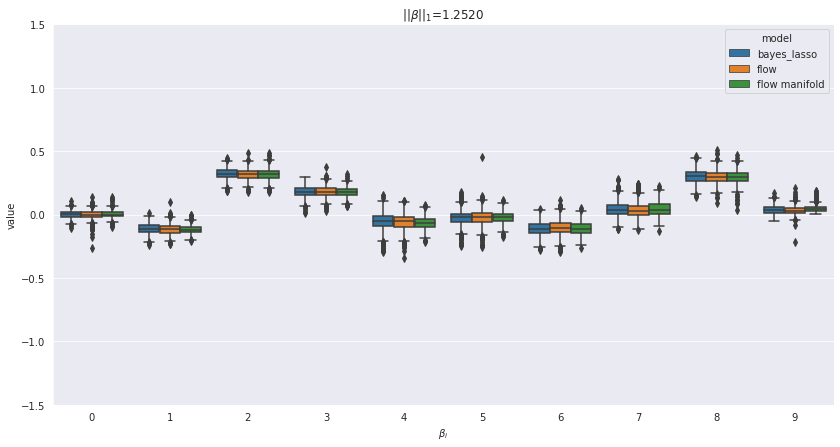

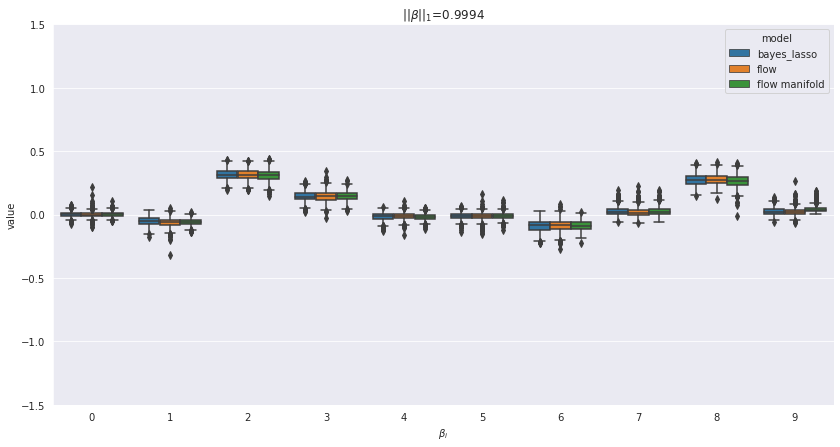

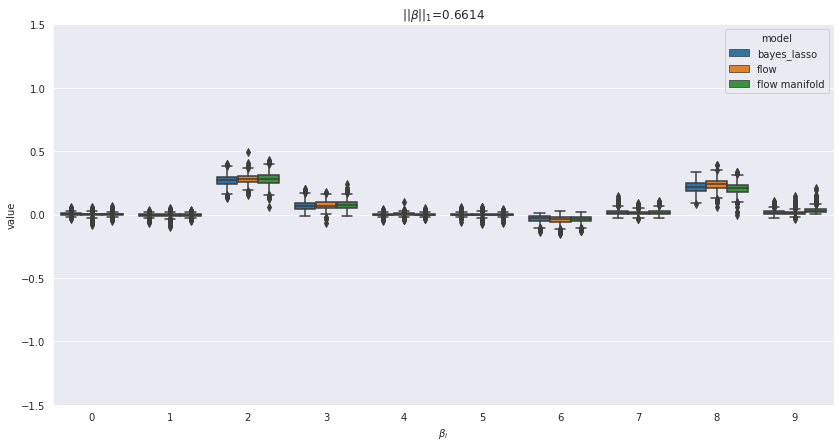

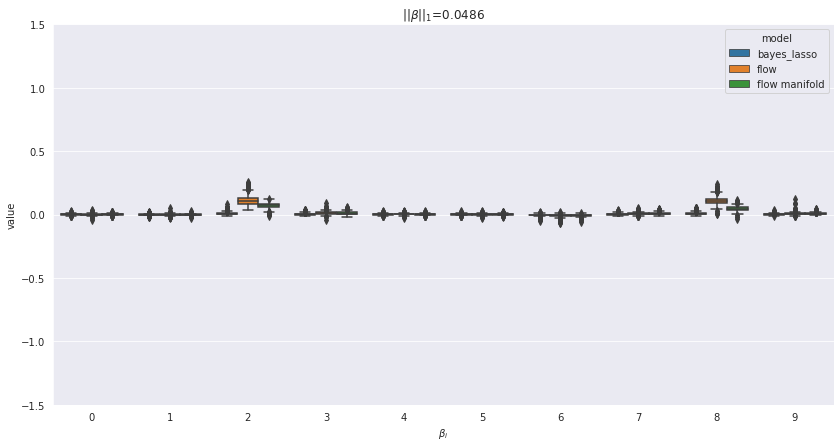

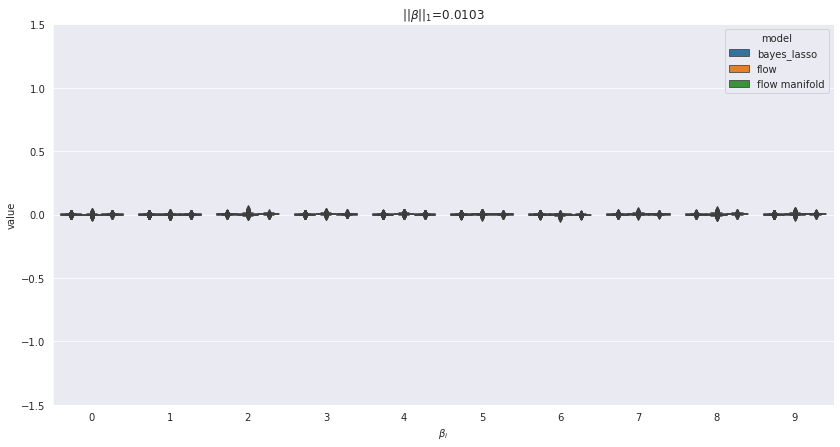

In [42]:
# plot comparison
for i, key_norm in enumerate(all_samples_bayes.keys()):
    plt.figure(figsize=(14,7))
    bayes_lasso_df = pd.DataFrame(all_samples_bayes[key_norm]).assign(model="bayes_lasso")
    flow_df = pd.DataFrame(flow_samples_np[i]).assign(model="flow")
    flow_manifold_df = pd.DataFrame(flow_manifold_samples[i]).assign(model="flow manifold")
    cdf = pd.concat([bayes_lasso_df, flow_df, flow_manifold_df])
    mdf = pd.melt(cdf, id_vars=['model'], var_name=r'$\beta_i$', value_name="value")
    sns.boxplot(x=r'$\beta_i$', y="value", hue="model", data=mdf)
    plt.title(r"$||\beta||_1$={}".format(key_norm))
    plt.ylim(-1.5,1.5)
    plt.savefig(f"./plots/box_plot_norm_{key_norm}.pdf")
    plt.show()

In [19]:
min_samples = min(samples_flow.shape[1], samples_bayes.shape[1])
bins_midpoints = 0.5 * (bins[1:]+bins[:-1])
# sample from NF on manifold
flow_manifold = utils.build_cond_flow_manifold(flow_dim, q=q, n_layers=5, context_features=128, hidden_features=256, device=device)
flow_manifold.load_state_dict(torch.load("./models/flow_manifold_T_1"))
norms_flow_torch = torch.from_numpy(bins_midpoints).to(device).to(torch.float32).view(-1,1)
manifold_samples = []
for i in tqdm.tqdm(range(min_samples//20)):
    flow_manifold_samples, log_probs_samples = flow_manifold.sample_and_log_prob(20, context=norms_flow_torch)
    manifold_samples.append(flow_manifold_samples.detach().cpu().numpy())
    del flow_manifold_samples, log_probs_samples
    torch.cuda.empty_cache()
flow_manifold_samples = np.concatenate(manifold_samples, 1)
del flow_manifold
torch.cuda.empty_cache()

100%|██████████| 16/16 [00:01<00:00, 15.90it/s]


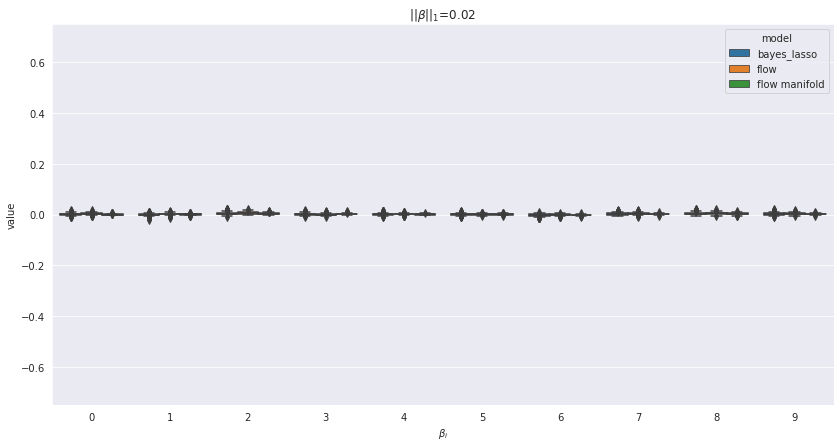

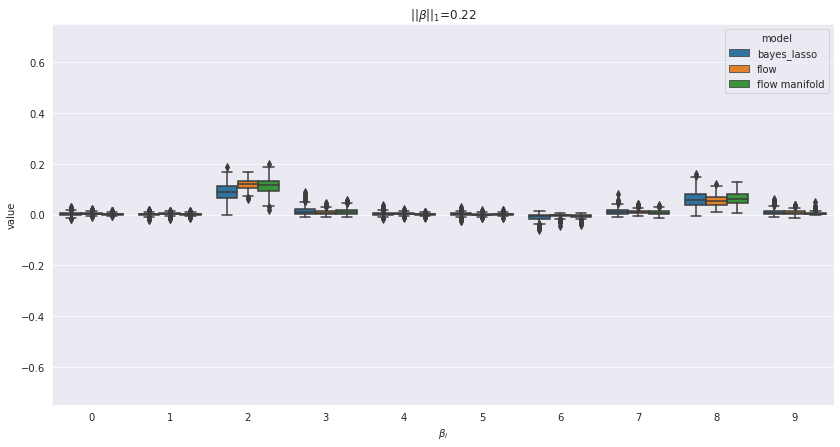

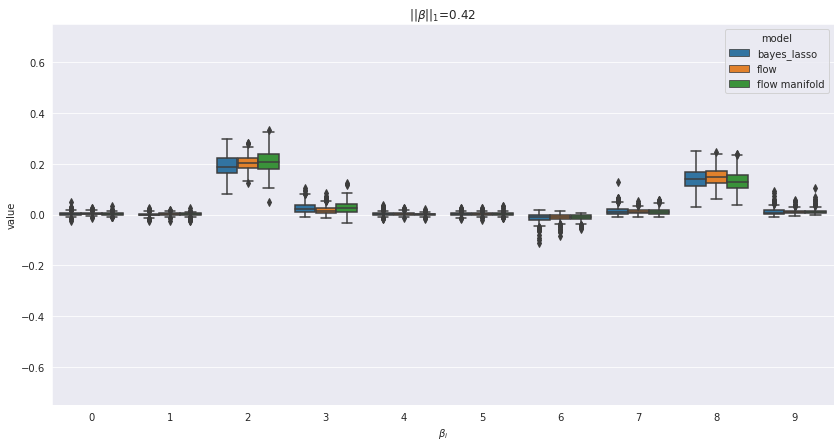

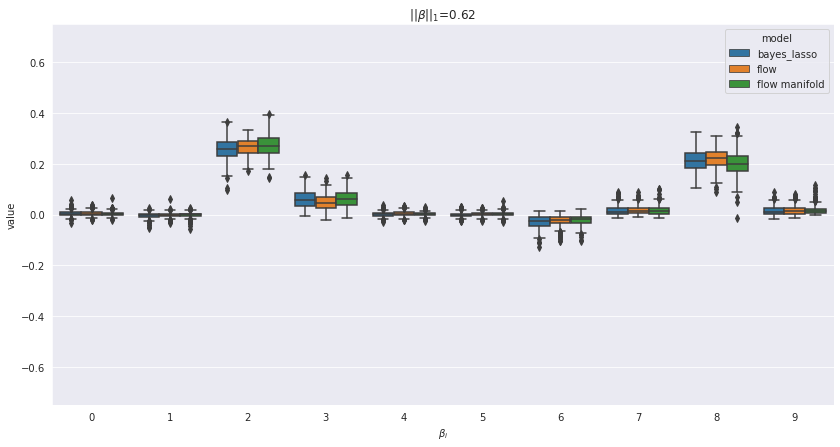

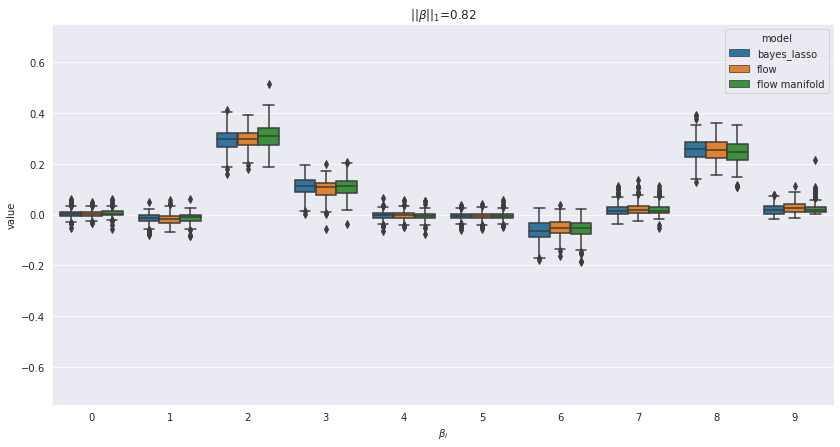

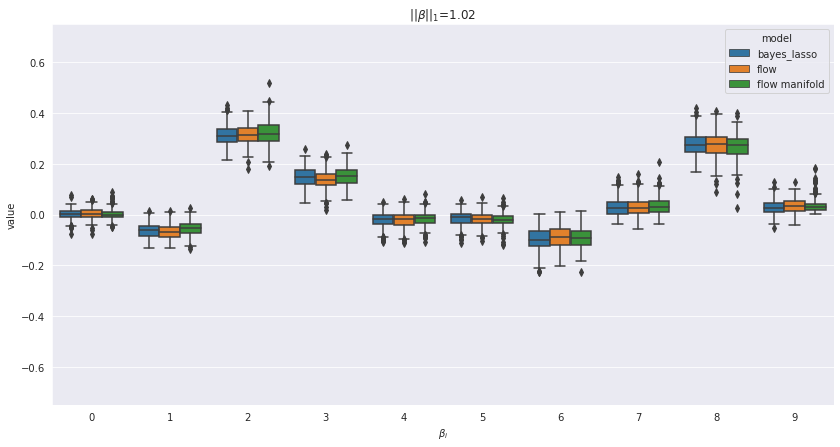

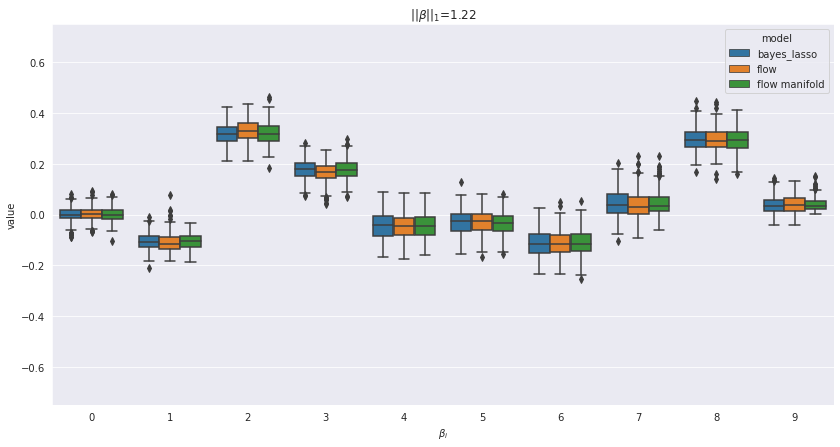

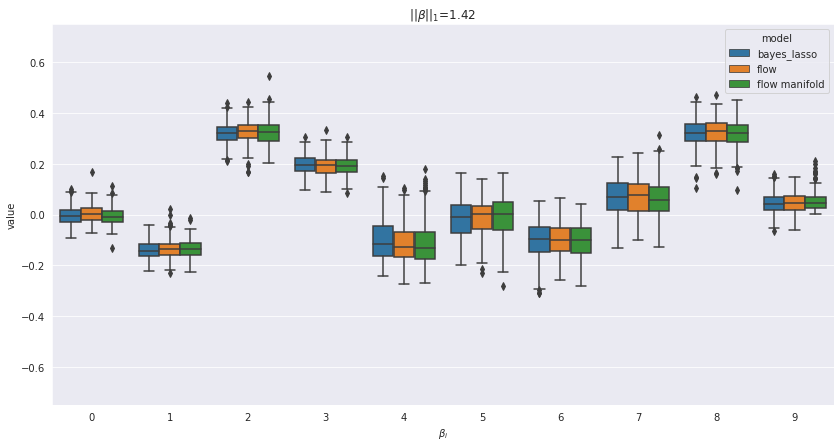

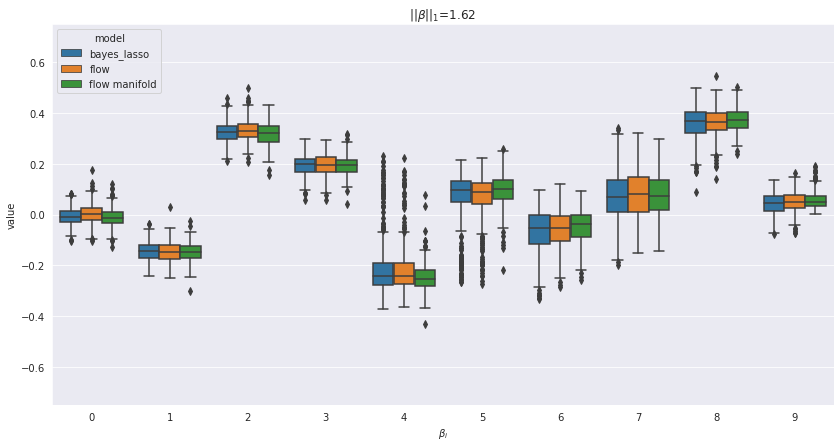

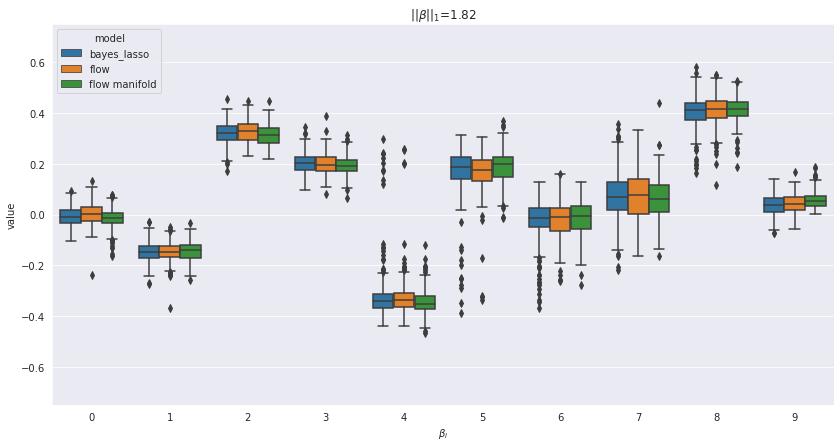

In [21]:
indeces = np.linspace(0,49,50).astype('int')[::5]

# plot comparison
for i in indeces:
    plt.figure(figsize=(14,7))
    bayes_lasso_df = pd.DataFrame(samples_bayes[i,:min_samples]).assign(model="bayes_lasso")
    flow_df = pd.DataFrame(samples_flow[i,:min_samples]).assign(model="flow")
    flow_manifold_df = pd.DataFrame(flow_manifold_samples[i]).assign(model="flow manifold")
    cdf = pd.concat([bayes_lasso_df, flow_df, flow_manifold_df])
    mdf = pd.melt(cdf, id_vars=['model'], var_name=r'$\beta_i$', value_name="value")
    sns.boxplot(x=r'$\beta_i$', y="value", hue="model", data=mdf, whis=1.5)
    plt.title(r"$||\beta||_1$={:.2f}".format(bins_midpoints[i]))
    plt.ylim(-0.75,0.75)
    # plt.savefig(f"./plots/box_plot_norm_{bins_midpoints[i]}.pdf")
    plt.show()